Visualization of representative ISs classified in 01 .ipynb

In [1]:
library(tidyverse)
library(cowplot)
library(latex2exp)
library(gggenes)
library(IRkernel)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
base_dir <- "is_variants_analysis"

In [3]:
annotations <- read_tsv(file.path(base_dir, "annotation_of_variants.blastn"), comment = '#',
                        col_names = c("sseqid", "qseqid", "qstart", "qend", "sstart", "send", "length", "evalue", "bitscore", "pident")) %>%
  filter(qseqid != "Full_IS1" | length > 3000)
reordered_levels <- annotations %>%
  group_by(sseqid) %>%
  summarise(max_s= max(sstart, send)) %>%
  arrange(desc(max_s)) %>%
  pull(sseqid)
annotations$sseqid <- factor(annotations$sseqid, levels = reordered_levels)
head(annotations)

Rows: 464 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sseqid, qseqid
dbl (8): qstart, qend, sstart, send, length, evalue, bitscore, pident

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L10-2.2.20,IS1-IRL,1,23,1,23,23,1.62e-07,42.8,100
L10-2.2.20,IS1-IRL,1,23,695,717,23,1.62e-07,42.8,100
L02-2.2.22,IS1-IRL,1,23,1,23,23,1.62e-07,42.8,100
L02-2.2.22,IS1-IRL,1,23,650,672,23,1.62e-07,42.8,100
L02-2.2.22,IS1-IRL,1,23,3751,3773,23,1.62e-07,42.8,100
L02-2.2.22,IS1-IRL,1,23,6852,6874,23,1.62e-07,42.8,100


## set the directions for visualization

In [4]:
# check if the length is within - 10bp or 10% of the fragment size
# [23, 699, 624, 699, 23, 3092]
# ['IS1-IRL', 'IS1FS', 'TetR', 'mScarlet-I', 'IS1-IRR', 'Full_IS1']
# create a data frame with the lengths of each qseqid
qseqid_lengths <- data.frame(
  qseqid = c('IS1-IRL', 'IS1FS', 'TetR', 'mScarlet-I', 'IS1-IRR', 'Full_IS1'),
  length.full = c(23, 699, 624, 699, 23, 3092)
)

fragment_df <- annotations %>% filter(qseqid != "Full_IS1") %>% 
left_join(qseqid_lengths, by = "qseqid") %>%
mutate(match = ifelse(length>length.full, 1, length/length.full)) 
fragment_df %>% head

sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident,length.full,match
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L10-2.2.20,IS1-IRL,1,23,1,23,23,1.62e-07,42.8,100,23,1
L10-2.2.20,IS1-IRL,1,23,695,717,23,1.62e-07,42.8,100,23,1
L02-2.2.22,IS1-IRL,1,23,1,23,23,1.62e-07,42.8,100,23,1
L02-2.2.22,IS1-IRL,1,23,650,672,23,1.62e-07,42.8,100,23,1
L02-2.2.22,IS1-IRL,1,23,3751,3773,23,1.62e-07,42.8,100,23,1
L02-2.2.22,IS1-IRL,1,23,6852,6874,23,1.62e-07,42.8,100,23,1


In [5]:
lengths <- read_csv(file.path(base_dir, "is_variant_lengths.csv"))
# reorder by length
lengths$id <- factor(lengths$id, levels = reorder(lengths$id, lengths$length))
lengths %>% head

Rows: 23 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): id
dbl (1): length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,length
<fct>,<dbl>
Anc,3092
L03-3.2.19,1877
L03-1.3.9,3215
L02-1.2.18,3742
L09-1.1.4,4090
L05-3.2.6,4230


In [6]:
full_is1 <- annotations %>% filter(qseqid == "Full_IS1") %>%
group_by(sseqid) %>% mutate(color = row_number()) %>% ungroup() 
full_is1 %>% head

sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident,color
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
L02-1.3.5,Full_IS1,1,3092,3696,6787,3092,0,5577,100.000,1
Anc,Full_IS1,1,3092,1,3092,3092,0,5577,100.000,1
L02-2.2.22,Full_IS1,1,3092,650,3742,3093,0,5570,99.968,1
L02-2.2.22,Full_IS1,1,3092,3751,6843,3093,0,5570,99.968,2
L02-2.2.22,Full_IS1,1,3092,6852,9944,3093,0,5570,99.968,3
L02-1.1.12,Full_IS1,1,3092,650,3742,3093,0,5570,99.968,1


In [7]:
# 4-4-3-21 partialy lacks the IS1-IRR 
full_is1 %>% arrange((length)) %>% head

sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident,color
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
L04-4.3.21,Full_IS1,1,3087,6347,3261,3088,0,5553,99.935,2
L02-1.3.5,Full_IS1,1,3092,3696,6787,3092,0,5577,100.000,1
Anc,Full_IS1,1,3092,1,3092,3092,0,5577,100.000,1
L05-1.3.19,Full_IS1,1,3092,3245,6335,3092,0,5569,99.968,1
L02-2.2.22,Full_IS1,1,3092,650,3742,3093,0,5570,99.968,1
L02-2.2.22,Full_IS1,1,3092,3751,6843,3093,0,5570,99.968,2


In [8]:
full_is1 <- full_is1 %>% filter(length > 3090)
full_is1 %>% arrange((length)) %>% head

sseqid,qseqid,qstart,qend,sstart,send,length,evalue,bitscore,pident,color
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
L02-1.3.5,Full_IS1,1,3092,3696,6787,3092,0,5577,100.000,1
Anc,Full_IS1,1,3092,1,3092,3092,0,5577,100.000,1
L05-1.3.19,Full_IS1,1,3092,3245,6335,3092,0,5569,99.968,1
L02-2.2.22,Full_IS1,1,3092,650,3742,3093,0,5570,99.968,1
L02-2.2.22,Full_IS1,1,3092,3751,6843,3093,0,5570,99.968,2
L02-2.2.22,Full_IS1,1,3092,6852,9944,3093,0,5570,99.968,3


In [9]:
fragment_df %>% pull(qseqid) %>% unique

[1] "IS1-IRL"    "IS1FS"      "TetR"       "mScarlet-I" "IS1-IRR"

In [10]:
fragment_df %>%
filter(! qseqid %in% c("IS1-IRL", "IS1-IRR")) %>%
mutate(qseqid = ifelse(qseqid == "IS1FS", "tpn", ifelse(qseqid == "TetR", "tetR", qseqid))) %>%
mutate(qseqid = ifelse(qseqid == "mScarlet-I", "rfp", qseqid)) %>%
mutate(qseqid = factor(qseqid, levels = c("tpn", "tetR", "rfp"))) %>%
pull(qseqid) %>% unique

[1] tpn  tetR rfp 
Levels: tpn tetR rfp

In [11]:
library(RColorBrewer)
cols_ <- c(RColorBrewer::brewer.pal(5, "Set2")[c(3,1)], "#be1521")
labs_ <- expression(italic("tpn"), italic("tetR"), italic("rfp"))
p <- ggplot() +
geom_segment(data = lengths, aes(x= 0, xend = length, y = id, yend = id), size = 0.5, color = "grey")+
geom_linerange(data = full_is1,
aes(xmin = sstart, xmax= send, y = sseqid, linetype = as.factor(color)), size = .6,
position = position_nudge(y = 0.4)) +
  scale_linetype_discrete(guide = "none")+
geom_gene_arrow(data =
  fragment_df %>%
  filter(! qseqid %in% c("IS1-IRL", "IS1-IRR")) %>%
  mutate(qseqid = ifelse(qseqid == "IS1FS", "tpn", ifelse(qseqid == "TetR", "tetR", qseqid))) %>%
  mutate(qseqid = ifelse(qseqid == "mScarlet-I", "rfp", qseqid)) %>%
  mutate(qseqid = factor(qseqid, levels = c("tpn", "tetR", "rfp"))),
  aes(xmin = sstart, xmax = send, y = sseqid, fill = qseqid, alpha = match==1),
  size = 0.1,
  arrowhead_width = grid::unit(2.5, "mm"),
  arrowhead_height = grid::unit(2.0, "mm"),
  arrow_body_height = grid::unit(1.0, "mm"),
  )+
  scale_alpha_discrete(guide = "none", range = c(0.5,1), name = "")+
  scale_fill_manual(values = cols_, labels = labs_, name ="") +
  scale_y_discrete(labels = c("Original", levels(lengths$id)[2:length(lengths$id)]))+
  scale_x_continuous(expand = expansion(add = c(100, 0)), limits = c(0, NA))+
geom_gene_arrow(data = fragment_df %>% filter(qseqid %in% c("IS1-IRL", "IS1-IRR")),
aes(xmin = sstart, xmax = send, y = sseqid), fill = "grey",
  arrowhead_width = grid::unit(0.5, "mm"),
  arrowhead_height = grid::unit(1.5, "mm"),
  arrow_body_height = grid::unit(0.1, "mm"),
  size = .3
  )+
  #geom_text(data = lengths %>% filter(id == "Anc"), aes(x = 4000, y = id, label = "3092 bp"), size = 8 * 5/14)+
  theme_minimal_vgrid(10) +
  theme(panel.grid.minor = element_blank(), axis.text.y = element_text(hjust=0),
    axis.ticks.y = element_blank(), axis.line.y = element_blank(),
    legend.position = c(1, 0.5), legend.justification = c(1, 0.5),
  ) +
  labs(x = "Length of IS Cluster (bp)", y = "Detected IS Variants", fill = "Gene")
ggsave("./is_variants_analysis/is_variants.png", p, width = 120, height = 110, units = "mm", dpi = 1000)
ggsave("./is_variants_analysis/is_variants.pdf", p, width = 120, height = 110, units = "mm", dpi = 1000)
ggsave("./is_variants_analysis/is_variants.svg", p, width = 120, height = 110, units = "mm", dpi = 1000)
ggsave("./is_variants_analysis/is_variants_90.svg", p, width = 90, height = 110, units = "mm", dpi = 1000)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Using alpha for a discrete variable is not advised.”


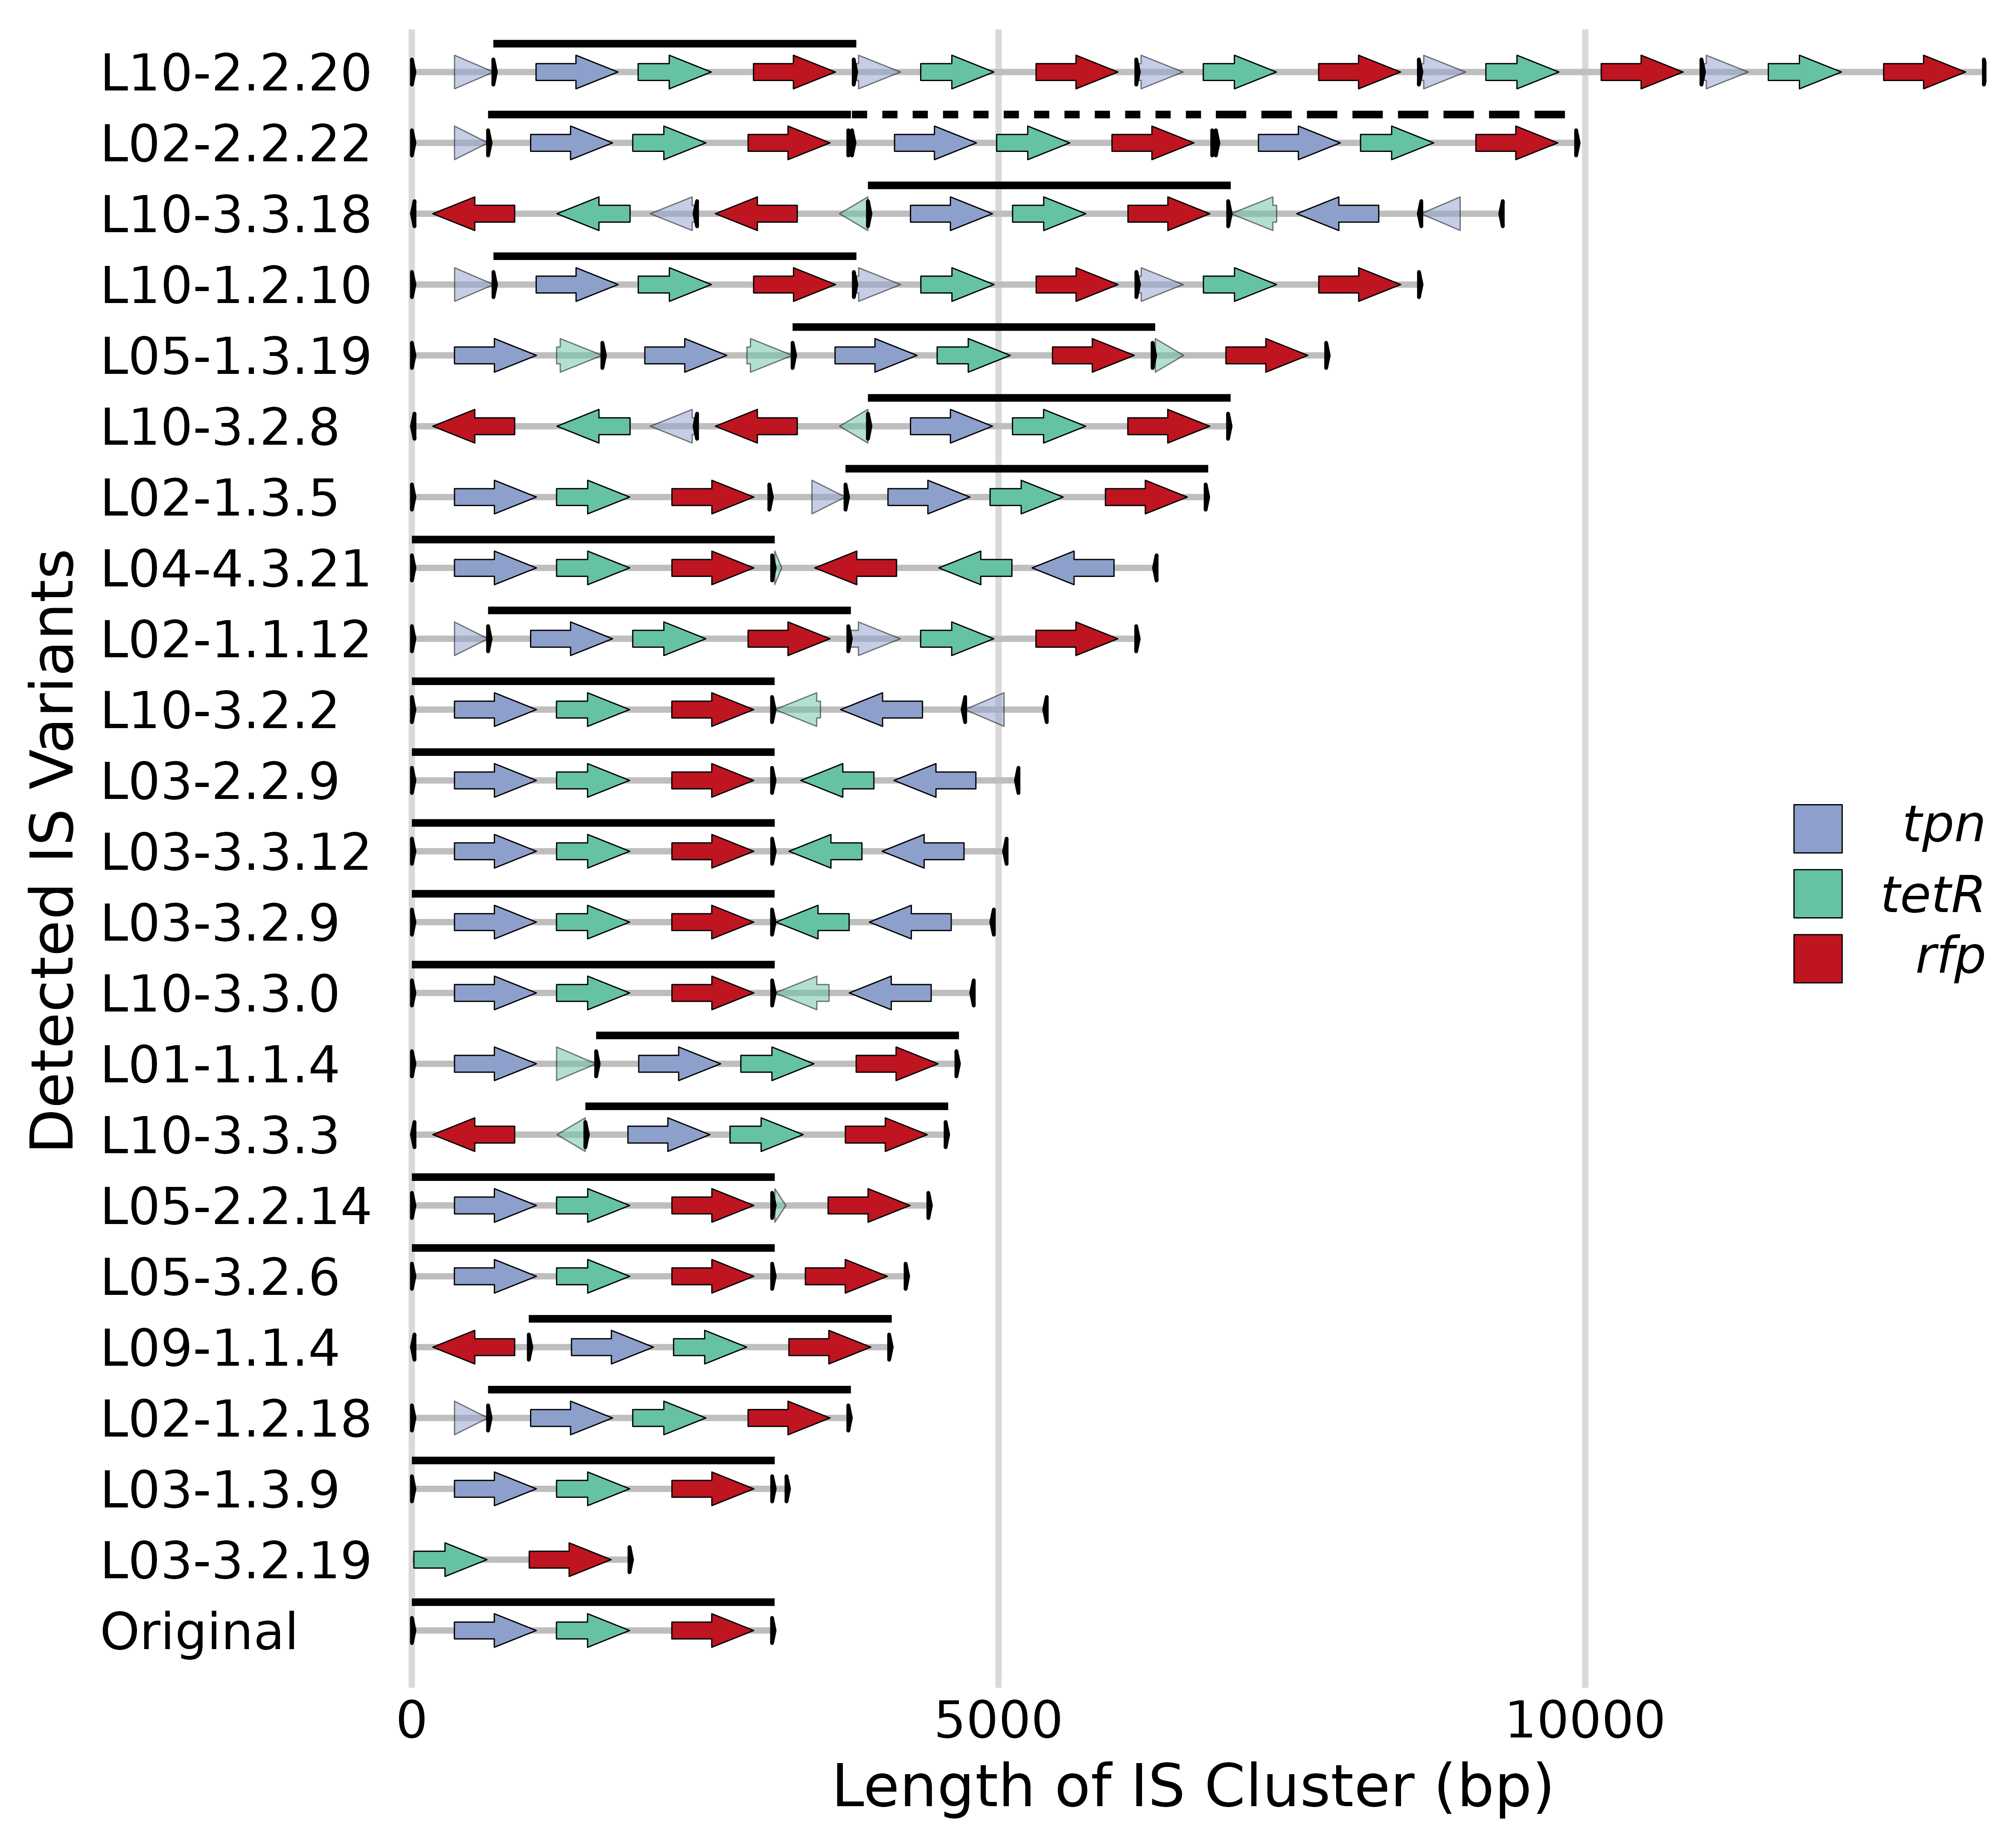

In [12]:
IRdisplay::display_png(file="./is_variants_analysis/is_variants.png")

Warning message:
“Using alpha for a discrete variable is not advised.”


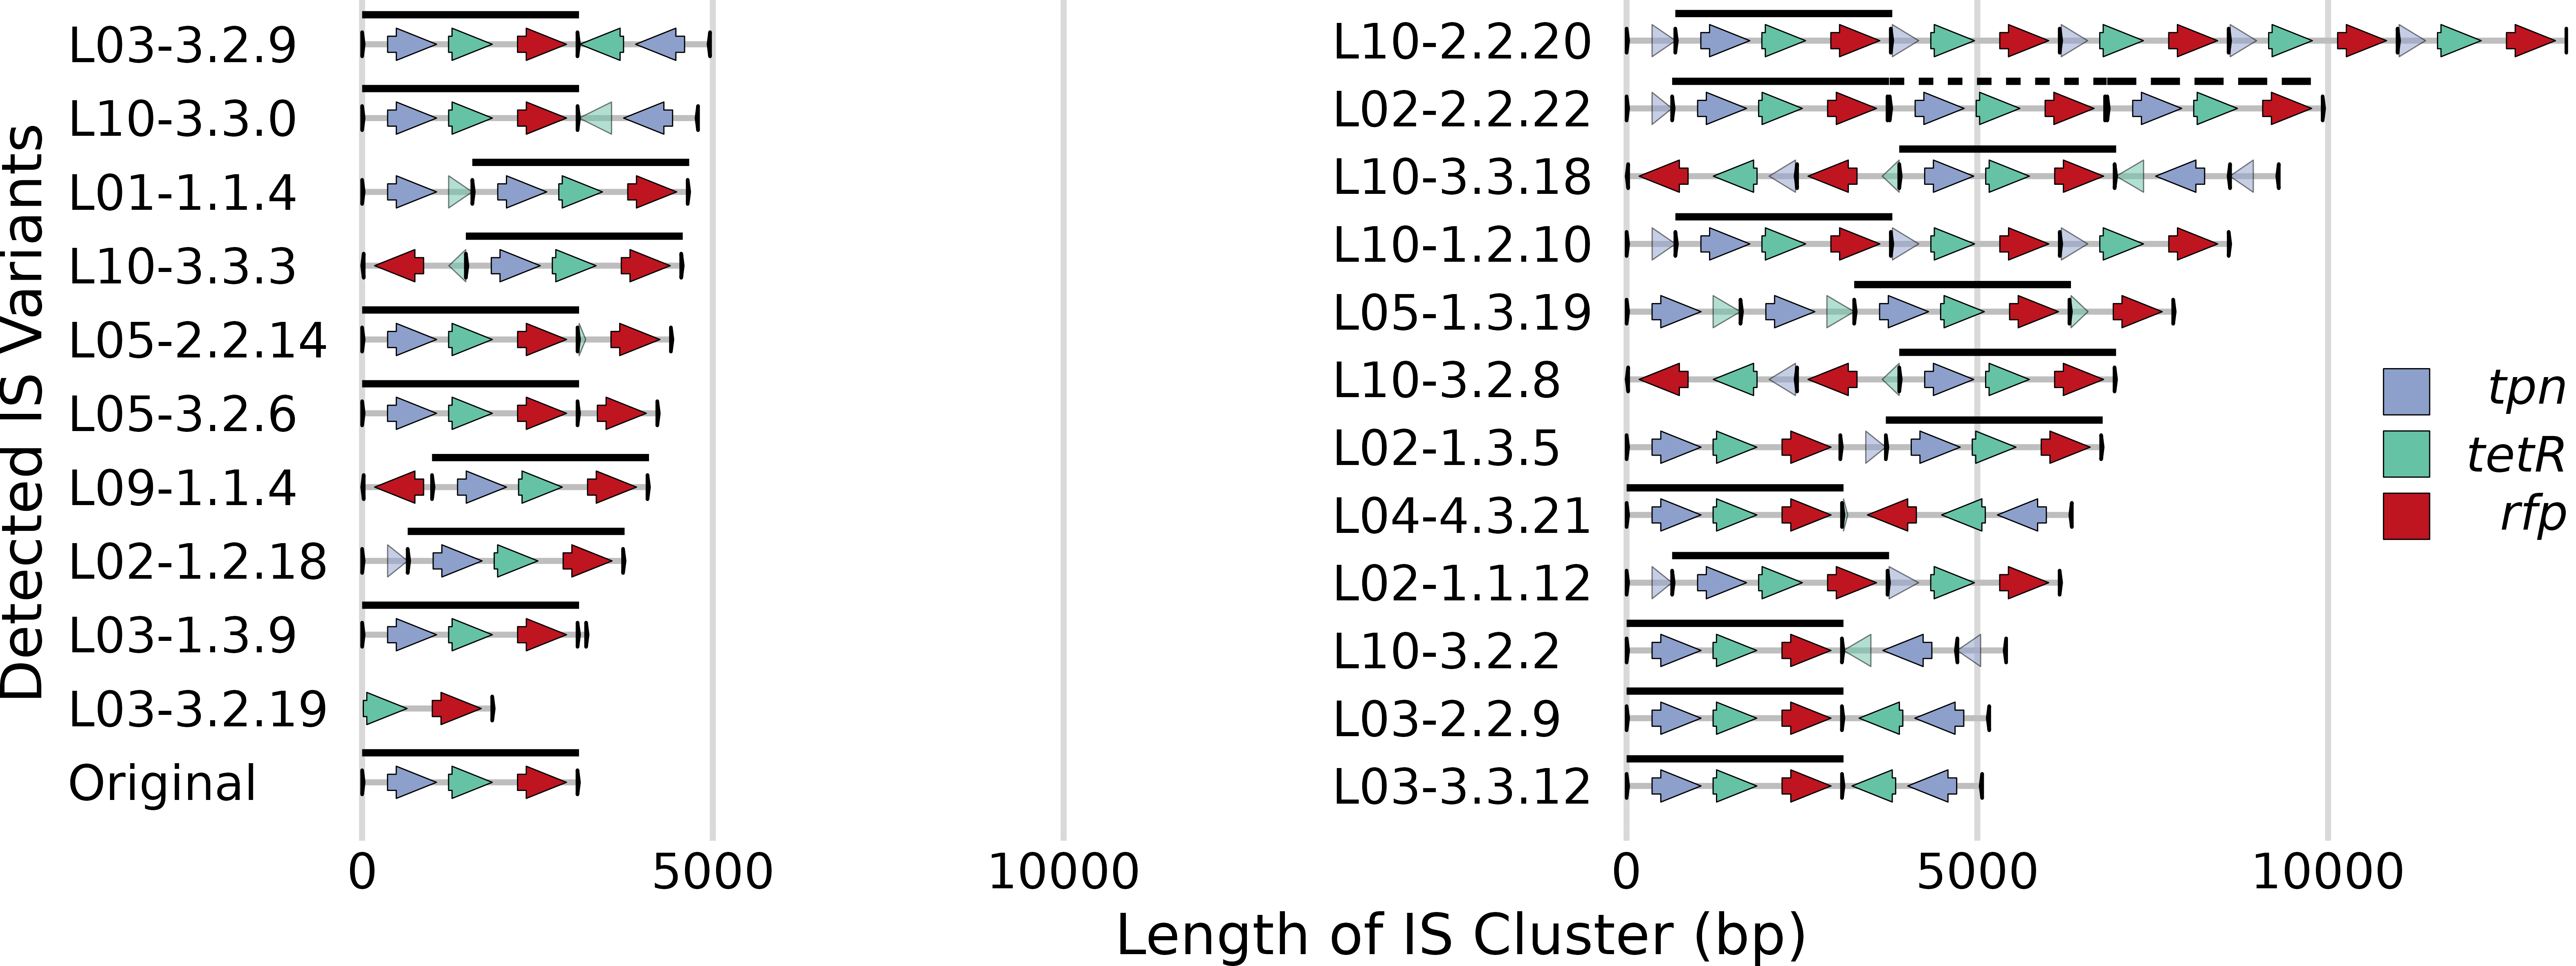

In [13]:
cols_ <- c(RColorBrewer::brewer.pal(5, "Set2")[c(3,1)], "#be1521")
labs_ <- expression(italic("tpn"), italic("tetR"), italic("rfp"))
p <- ggplot() +
geom_segment(data = lengths %>% mutate(sseqid = id), aes(x= 0, xend = length, y = id, yend = id), size = 0.5, color = "grey")+
geom_linerange(data = full_is1,
  aes(xmin = sstart, xmax= send, y = sseqid, linetype = as.factor(color)), size = .6,
  position = position_nudge(y = 0.4)) +
  scale_linetype_discrete(guide = "none")+
  facet_wrap(~ sseqid %in% (lengths %>% pull(id) %>% unique %>% tail(12)), ncol = 2, scales = "free_y") +
geom_gene_arrow(data =
  fragment_df %>%
  filter(! qseqid %in% c("IS1-IRL", "IS1-IRR")) %>%
  mutate(qseqid = ifelse(qseqid == "IS1FS", "tpn", ifelse(qseqid == "TetR", "tetR", qseqid))) %>%
  mutate(qseqid = ifelse(qseqid == "mScarlet-I", "rfp", qseqid)) %>%
  mutate(qseqid = factor(qseqid, levels = c("tpn", "tetR", "rfp"))),
  aes(xmin = sstart, xmax = send, y = sseqid, fill = qseqid, alpha = match==1),
  size = 0.1,
  arrowhead_width = grid::unit(2.5, "mm"),
  arrowhead_height = grid::unit(2.0, "mm"),
  arrow_body_height = grid::unit(1.0, "mm"),
  )+
  scale_alpha_discrete(guide = "none", range = c(0.5,1), name = "")+
  scale_fill_manual(values = cols_, labels = labs_, name ="") +
  # create label for each facet
  #scale_y_discrete(labels = c("Original", levels(lengths$id)[2:length(lengths$id)]))+
  scale_y_discrete(labels = function(x){
    ifelse(x == "Anc", "Original", x)
  })+
  scale_x_continuous(expand = expansion(add = c(100, 0)), limits = c(0, NA))+
geom_gene_arrow(data = fragment_df %>% filter(qseqid %in% c("IS1-IRL", "IS1-IRR")),
aes(xmin = sstart, xmax = send, y = sseqid), fill = "grey",
  arrowhead_width = grid::unit(0.5, "mm"),
  arrowhead_height = grid::unit(1.5, "mm"),
  arrow_body_height = grid::unit(0.1, "mm"),
  size = .3
  )+
  #geom_text(data = lengths %>% filter(id == "Anc"), aes(x = 4000, y = id, label = "3092 bp"), size = 8 * 5/14)+
  theme_minimal_vgrid(10) +
  theme(panel.grid.minor = element_blank(), axis.text.y = element_text(hjust=0),
    axis.ticks.y = element_blank(), axis.line.y = element_blank(),
    legend.position = c(1, 0.5), legend.justification = c(1, 0.5),
    strip.background = element_blank(),
    strip.text.x = element_blank(),
  ) +
  labs(x = "Length of IS Cluster (bp)", y = "Detected IS Variants", fill = "Gene") 

p<- p + theme(plot.margin=grid::unit(c(0,0.5,0,0), "mm"))
ggsave("./is_variants_analysis/is_variants_2col.png", p, width = 160, height = 60, units = "mm", dpi = 1000)
ggsave("./is_variants_analysis/is_variants_2col.pdf", p, width = 160, height = 60, units = "mm", dpi = 1000)
ggsave("./is_variants_analysis/is_variants_2col.svg", p, width = 160, height = 60, units = "mm", dpi = 1000)
IRdisplay::display_png(file="./is_variants_analysis/is_variants_2col.png")

## Visualization of only recA+ for presentation

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [43, 94, 146, 189, 231].”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `parent = as.integer(str_sub(parent, 2, 3))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1 rows [1].”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `parent = as.integer(str_sub(parent, 2, 3))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1 rows [2].”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `parent = as.integer(str_sub(parent, 2, 3))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Using alpha for a discrete variable is not advised.”


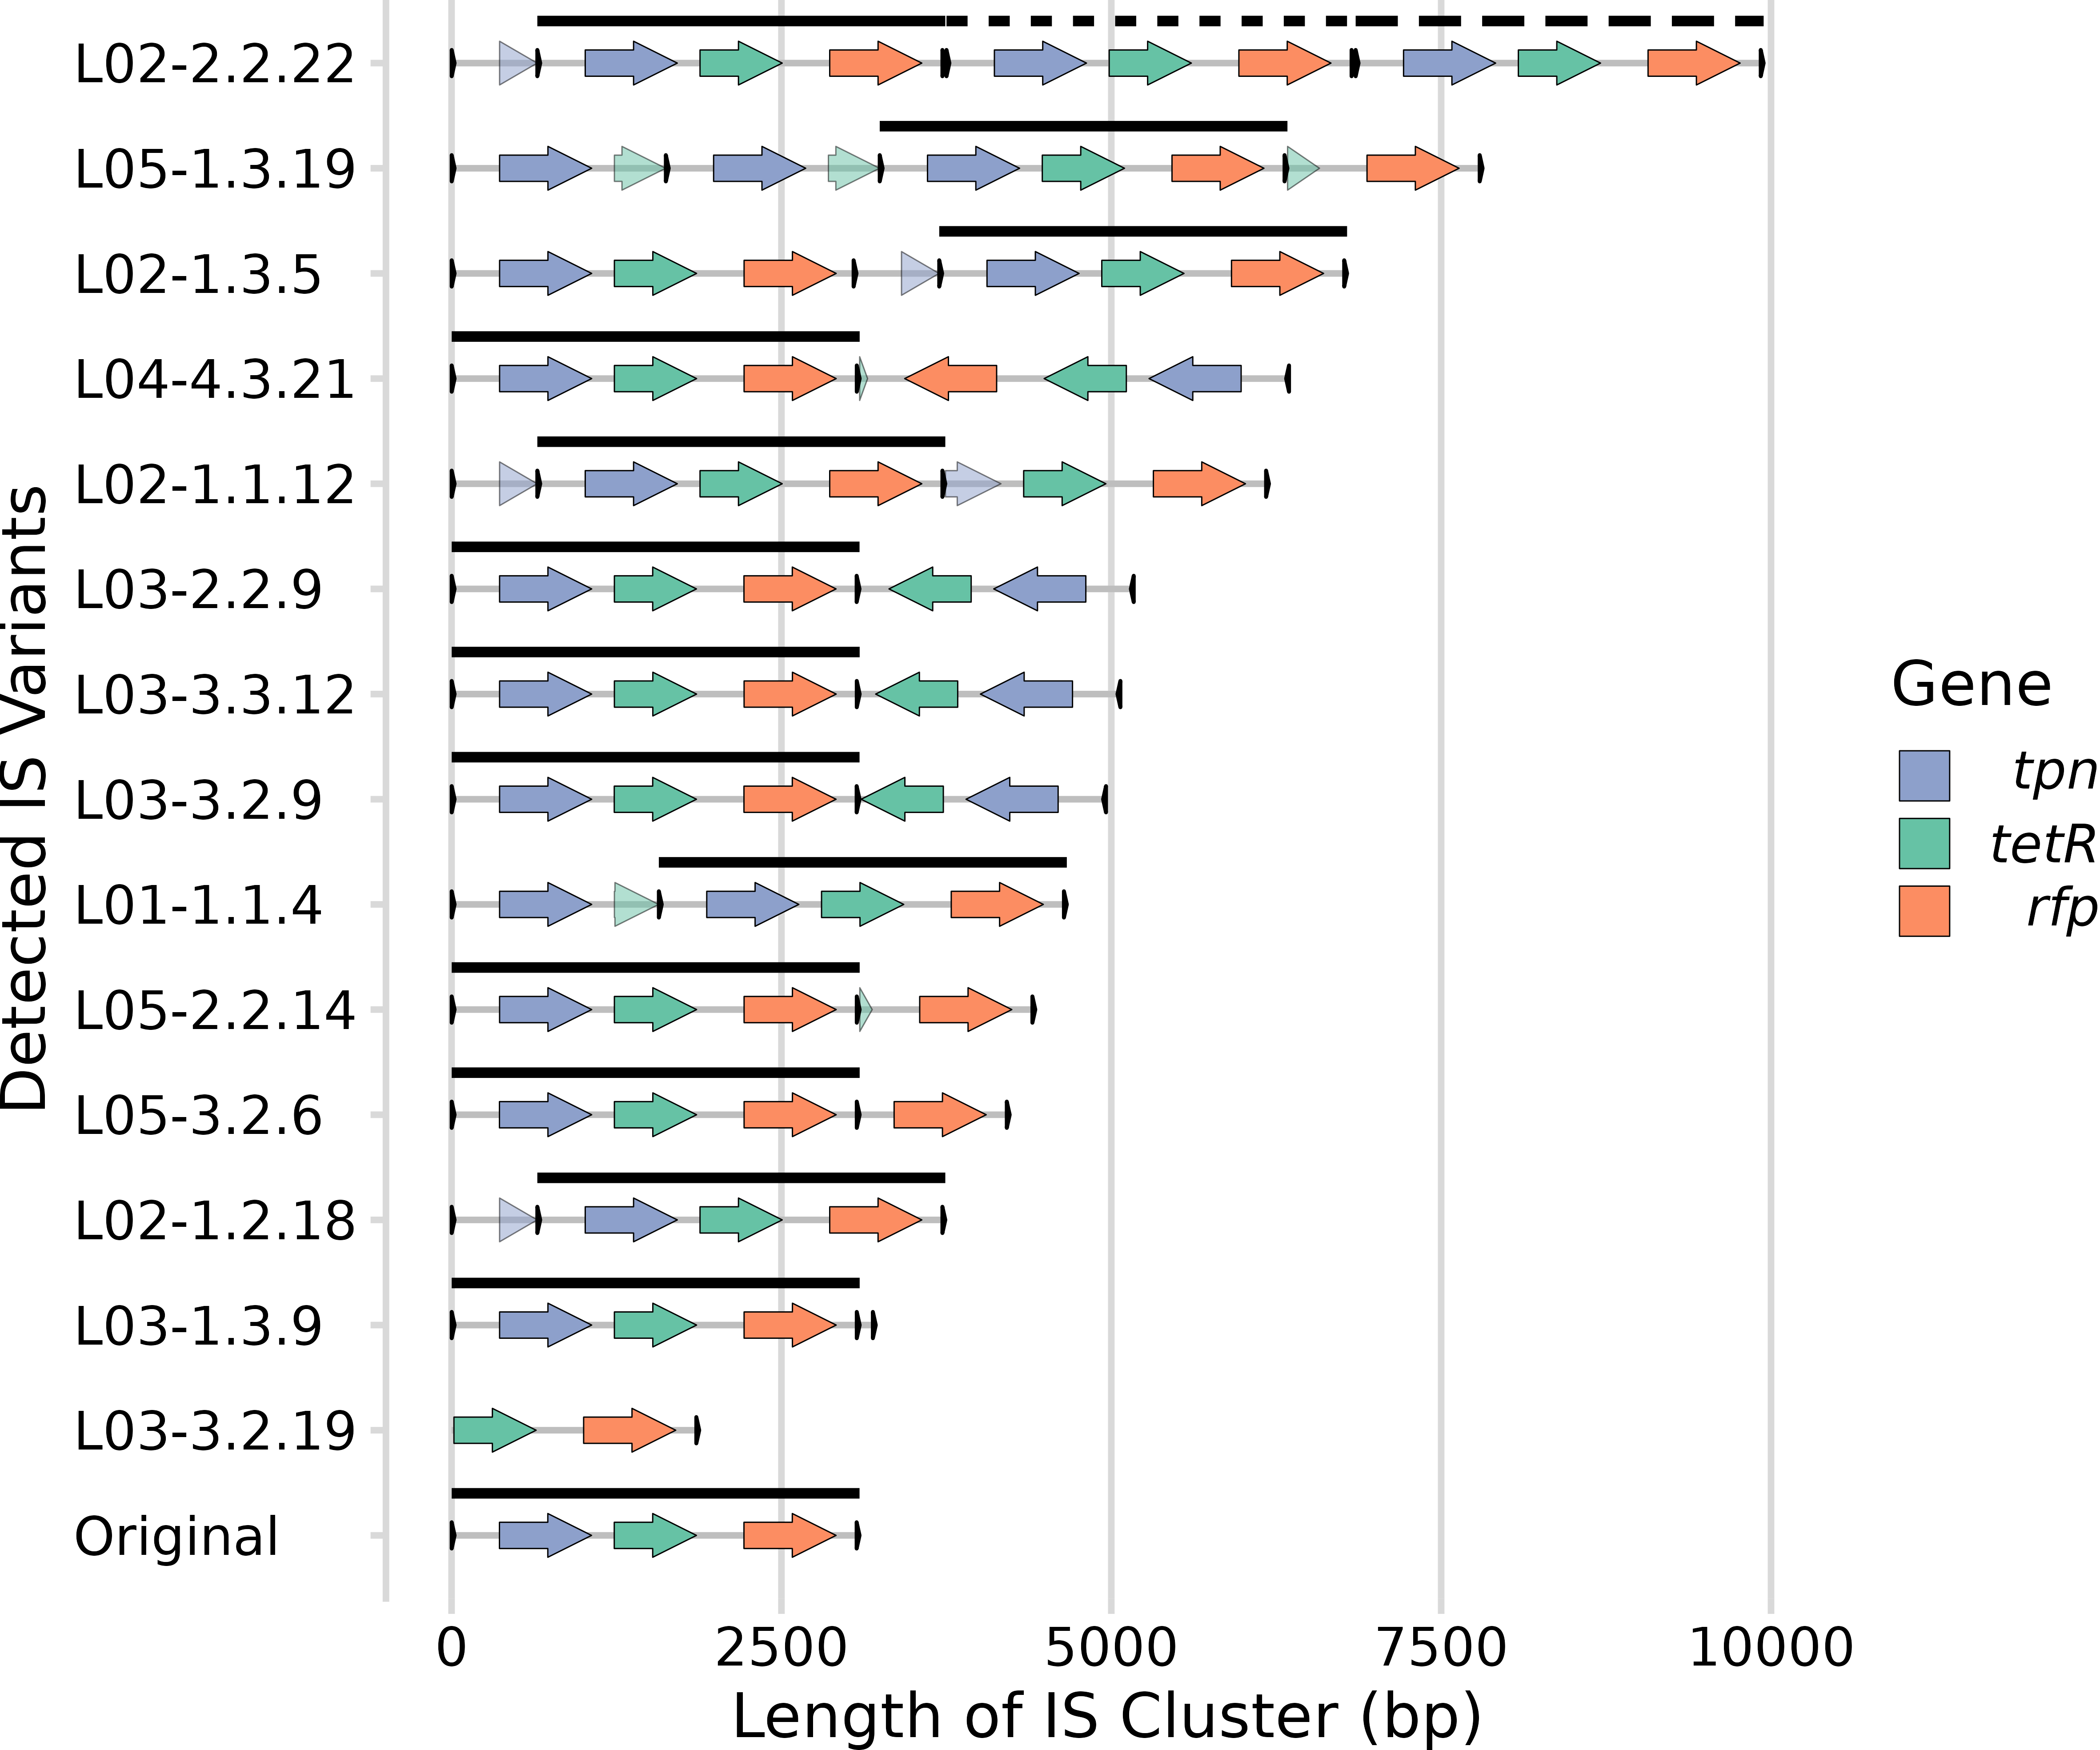

In [14]:
figure_name <- "is_variants_recAP"

fragment_df.recAP <- fragment_df %>%
separate(sseqid, c("parent", "line.ISID"), sep = "-", remove = F) %>%
mutate(parent = as.integer(str_sub(parent, 2, 3))) %>%
filter(parent <= 6 | sseqid == "Anc") 

lengths.recAP <- lengths %>%
separate(id, c("parent", "line.ISID"), sep = "-", remove = F) %>%
mutate(parent = as.integer(str_sub(parent, 2, 3))) %>%
filter(parent <= 6 | id == "Anc") %>%
mutate(id = factor(id , levels = id))

p <- ggplot() +
# Draw lines correspoinding to the length of the IS1 cluster
geom_segment(data = lengths.recAP,
aes(x= 0, xend = length, y = id, yend = id), size = 0.5, color = "grey")+
geom_linerange(data = full_is1 %>% separate(sseqid, c("parent", "line.ISID"), sep = "-", remove = F) %>%
  mutate(parent = as.integer(str_sub(parent, 2, 3))) %>% filter(parent <= 6 | sseqid == "Anc"),
aes(xmin = sstart, xmax= send, y = sseqid, linetype = as.factor(color)), size = .8,
position = position_nudge(y = 0.4)) +
  scale_linetype_discrete(guide = "none")+
geom_gene_arrow(data = 
  fragment_df.recAP %>%
  filter(! qseqid %in% c("IS1-IRL", "IS1-IRR")) %>%
  mutate(qseqid = ifelse(qseqid == "IS1FS", "tpn", ifelse(qseqid == "TetR", "tetR", qseqid))) %>%
  mutate(qseqid = ifelse(qseqid == "mScarlet-I", "rfp", qseqid)) %>%
  mutate(qseqid = factor(qseqid, levels = c("tpn", "tetR", "rfp"))),
  aes(xmin = sstart, xmax = send, y = sseqid, fill = qseqid, alpha = match==1),
  size = 0.1,
  arrowhead_width = grid::unit(2.5, "mm"),
  arrowhead_height = grid::unit(2.5, "mm"),
  arrow_body_height = grid::unit(1.5, "mm"),
  )+
  scale_alpha_discrete(guide = "none", range = c(0.5,1))+
  scale_fill_manual(values = brewer.pal(4, "Set2")[c(3,1,2)], labels = labs_) +
  scale_y_discrete(labels = c("Original", levels(lengths.recAP$id)[2:length(lengths.recAP$id)]))+
geom_gene_arrow(data = fragment_df.recAP %>% filter(qseqid %in% c("IS1-IRL", "IS1-IRR")),
aes(xmin = sstart, xmax = send, y = sseqid), fill = "grey",
  arrowhead_width = grid::unit(0.5, "mm"),
  arrowhead_height = grid::unit(1.5, "mm"),
  arrow_body_height = grid::unit(0.1, "mm"),
  size = .3
  )+
  #geom_text(data = lengths %>% filter(id == "Anc"), aes(x = 4000, y = id, label = "3092 bp"), size = 8 * 5/14)+
  theme_minimal_vgrid(10) +
  theme(panel.grid.minor = element_blank(), axis.text.y = element_text(hjust=0)) +
  labs(x = "Length of IS Cluster (bp)", y = "Detected IS Variants", fill = "Gene")
p<- p + theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))
ggsave(file.path("./is_variants_analysis", paste0(figure_name, ".png")), p, width = 120, height = 100, units = "mm", dpi = 1000)
ggsave(file.path("./is_variants_analysis", paste0(figure_name, ".pdf")), p, width = 120, height = 100, units = "mm", dpi = 1000)
ggsave(file.path("./is_variants_analysis", paste0(figure_name, ".svg")), p, width = 120, height = 100, units = "mm", dpi = 1000)

IRdisplay::display_png(file=file.path("./is_variants_analysis", paste0(figure_name, ".png")))